In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
from distgen.physical_constants import unit_registry, PHYSICAL_CONSTANTS

import scipy.constants as const

h = PHYSICAL_CONSTANTS["Planck constant in eV/Hz"]
c = PHYSICAL_CONSTANTS["speed of light in vacuum"]
hc = h * c

MC2 = PHYSICAL_CONSTANTS.species("electron")["mc2"]

me = PHYSICAL_CONSTANTS.species("electron")["mass"]

In [3]:
from matplotlib import pyplot as plt
import numpy as np

# Fermi-Dirac 3 Step Barrier Momentum Distribution
---
Calculates the PDF for electrons emitted from a photocathode following the
model described in [1]. Shortly, electrons are initially populated in momentum space as 
in the Sommerfeld model. They escape over the work function barrier when their 
longitudinal energy is high enough and lose momentum along the direction of the surface 
normal to satisfy energy conservation. For the purposes of referencing in published 
research, this sampling concept is the same described in [2].

    [1] Dowell, D. H., & Schmerge, J. F. (2009). Quantum efficiency and thermal emittance of 
        metal photocathodes. Physical Review Special Topics - Accelerators and Beams, 12(7). 
        https://doi.org/10.1103/PhysRevSTAB.12.074201

    [2] Pierce, C. M., Durham, D. B., Riminucci, F., Dhuey, S., Bazarov, I., Maxson, J.,
        Minor, A. M., & Filippetto, D. (2023). Experimental Characterization of Photoemission
        from Plasmonic Nanogroove Arrays. Physical Review Applied, 19(3), 034034.
        https://doi.org/10.1103/PhysRevApplied.19.034034

## Full Distgen Example

In [4]:
from distgen import Generator

In [5]:
photon_energy = 2.5 * unit_registry("eV")
laser_wavelength = hc / photon_energy
cathode_temperature = 300 * unit_registry("K")
fermi_energy = 6 * unit_registry("eV")
cathode_work_function = 2 * unit_registry("eV")

In [6]:
D = Generator("data/fermi_dirac_3step_barrier_photocathode.in.yaml", verbose=1)

D["p_polar_angle_dist:photon_wavelength"] = laser_wavelength.to("nm").magnitude
D["p_polar_angle_dist:temperature"] = cathode_temperature
D["p_polar_angle_dist:fermi_energy"] = fermi_energy
D["p_polar_angle_dist:work_function"] = cathode_work_function

In [7]:
P = D.run()

Distribution format: None
Output file: None

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 10 pC.
   Number of macroparticles: 200000.
   Assuming cylindrical symmetry...
   Assuming cylindrical momentum symmetry...
   r distribution: radial Gaussian
      Non-truncated sigma_xy: 1 mm
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   |p| and polar angle distribution: Fermi-Dirac 3 Step Barrier Photocathode Model
      laser wavelength = 495.937 nm, photon energy = 2.5 eV
      cathode temperature = 300 K, cathode work function = 2 eV, Fermi energy = 6 eV
   azimuthal angle distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   t distribution: uniform
      min_t = -17.3205 ps, max_t = 17.3205 ps, avg_t = 0 ps, sigma_t:  10 ps
   Shifting avg_x = -1.75251E-06 mm -> 0 mm
   Scaling sigma_x = 0.999928 mm -> 1 mm
   Shifting avg_y = 2.14895E-05 mm -> 0 mm
   Scaling sigma_y = 0.999965 mm -> 1 m

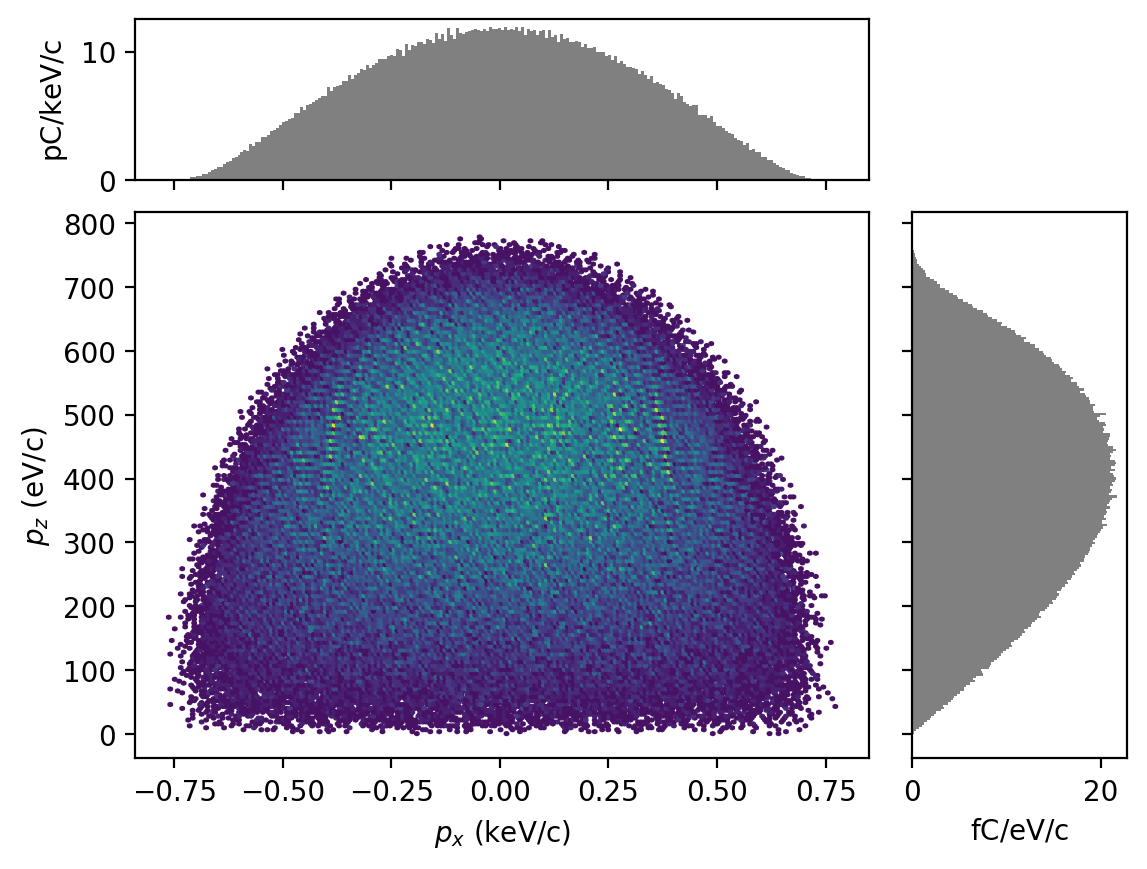

In [8]:
P.plot("px", "pz")

## Original Implementation (courtesy of C. Pierce)

In [9]:
# Fetch constants from scipy
kb = const.value("Boltzmann constant in eV/K")
mc2 = const.value("electron mass energy equivalent in MeV") * 1e6


def fermi_dirac(e, mu, t, t_cutoff=1e-3):
    """
    Fermi-Dirac distribution
    :param e: energy to evaluate at
    :param mu: Fermi energy
    :param t: Temperature
    :param t_cutoff: Clip the temperature at this value to avoid divide by zero
    :return: value of the Fermi-Dirac distribution
    """
    return 1 / (
        1 + np.exp(np.clip((e - mu) / (kb * np.clip(t, t_cutoff, None)), -256, 256))
    )


def dowell_schmerge_pdf_int(px, py, pz, fermi_energy, temp, photon_energy, workfun):
    e = (px**2 + py**2 + pz**2) / 2 / mc2
    p_excite = (1 - fermi_dirac(e + photon_energy, fermi_energy, temp)) * fermi_dirac(
        e, fermi_energy, temp
    )
    p_transport = pz > 0
    p_escape = pz**2 / 2 / mc2 + photon_energy >= fermi_energy + workfun
    return p_excite * p_transport * p_escape


def ds_transform(px, py, pz, fermi_energy, photon_energy, workfun):
    a = np.sqrt(
        1 - photon_energy / ((px**2 + py**2 + pz**2) / 2 / mc2 + fermi_energy + workfun)
    )
    return px * a, py * a, np.sqrt(pz**2 + 2 * mc2 * (fermi_energy + workfun)) * a


def ds_jacobian_factor(px, py, pz, fermi_energy, photon_energy, workfun):
    num = pz * np.sqrt(
        px**2 + py**2 + pz**2 + 2 * mc2 * (fermi_energy + workfun - photon_energy)
    )
    den = np.sqrt(
        (pz**2 + 2 * mc2 * (fermi_energy + workfun))
        * (px**2 + py**2 + pz**2 + 2 * mc2 * (fermi_energy + workfun))
    )
    return num / den


def dowell_schmerge_pdf(px, py, pz, photon_energy, workfun, temp, fermi_energy):
    """
    :params px: x component of momentum (in eV/c)
    :params py: y component of momentum (in eV/c)
    :params pz: z component of momentum (in eV/c)
    :params photon_energy: photon energy of driving laser (in eV)
    :params workfun: photocathode work function (in eV)
    :params temp: photocathode temperature (in K)
    :params fermi_energy: photocathode Fermi energy (in eV; note, PDF should be insensitive to this value)
    :return: unnormalized density of the emitted electrons at this momentum
    """
    a = ds_jacobian_factor(px, py, pz, fermi_energy, photon_energy, workfun)
    return a * dowell_schmerge_pdf_int(
        *ds_transform(px, py, pz, fermi_energy, photon_energy, workfun),
        fermi_energy,
        temp,
        photon_energy,
        workfun,
    )


def dowell_schmerge_pdf_bounds(photon_energy, workfun, temp, fermi_energy, n_tails=4):
    """
    Calculates bounding box of the non-zero part of the PDF
    :param temp: photocathode emperature (in K)
    :param photon_energy: photon energy of the driving laser (in eV)
    :param workfun: photocathode work function (in eV)
    :param n_tails: amount of Fermi tail to include (in units of kB*T)
    :return: (xl, xu), (yl, yu), (zl, zu), the lower (l) and upper (u) bounds along each axis (x, y, z)
    """
    a = np.sqrt(2 * mc2 * (photon_energy - workfun + kb * temp * n_tails))
    return [(-a, a), (-a, a), (0.0, a)]


def dowell_schmerge_pdf_spherical(p, theta, photon_energy, workfun, temp, fermi_energy):
    return dowell_schmerge_pdf(
        p * np.cos(theta),
        0.0,
        p * np.sin(theta),
        photon_energy,
        workfun,
        temp,
        fermi_energy,
    )


def dowell_schmerge_pdf_bounds_spherical(
    photon_energy, workfun, temp, fermi_energy, n_tails=4
):
    (_, a), _, _ = dowell_schmerge_pdf_bounds(
        photon_energy, workfun, temp, fermi_energy, n_tails=n_tails
    )
    return (0, a), (0, np.pi / 2)

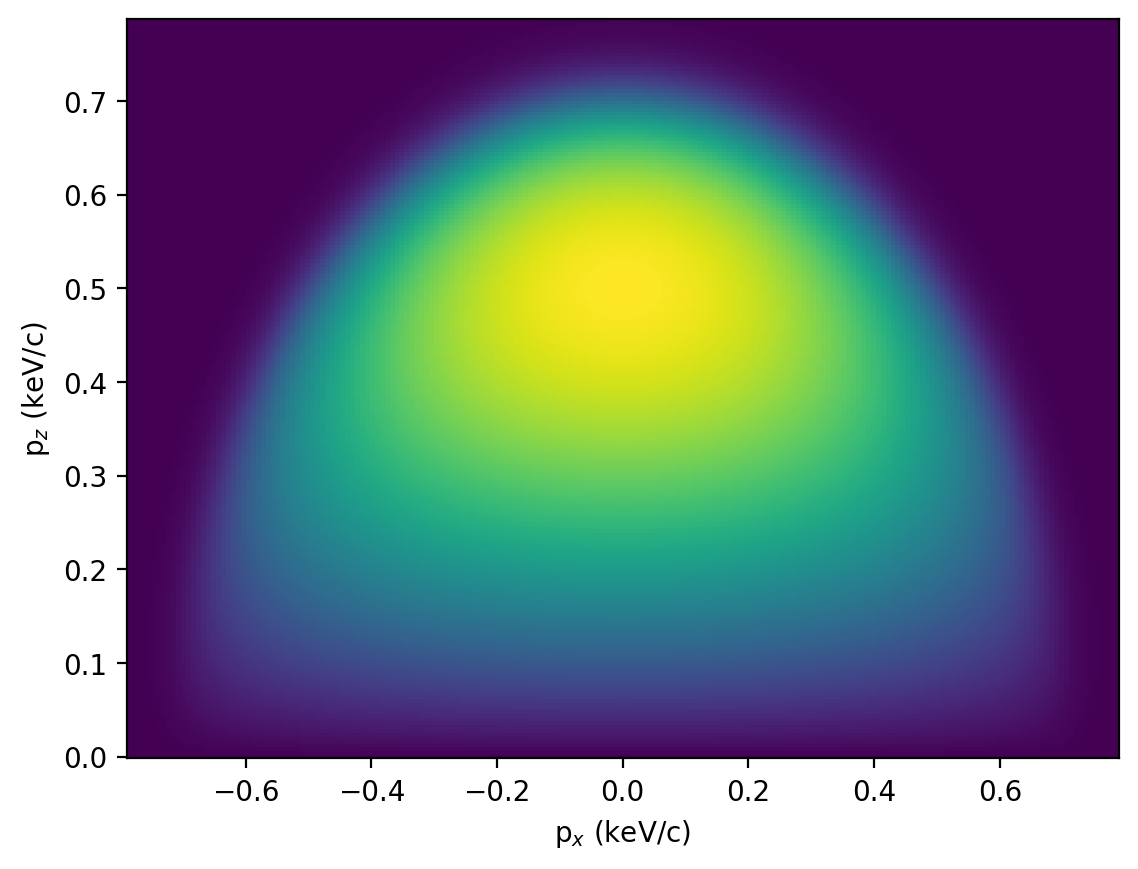

In [10]:
# Plot the projection onto px, pz
n_points = 200
(bxm, bxp), (bym, byp), (bzm, bzp) = dowell_schmerge_pdf_bounds(
    photon_energy.magnitude,
    cathode_work_function.magnitude,
    cathode_temperature.magnitude,
    fermi_energy.magnitude,
)
px, py, pz = np.mgrid[
    bxm : bxp : 1j * n_points, bym : byp : 1j * n_points, bzm : bzp : 1j * n_points
]

rho = np.sum(
    dowell_schmerge_pdf(
        px,
        py,
        pz,
        photon_energy.magnitude,
        cathode_work_function.magnitude,
        cathode_temperature.magnitude,
        fermi_energy.magnitude,
    ),
    axis=1,
)
plt.pcolormesh(1e-3 * px[:, 0, :], 1e-3 * pz[:, 0, :], rho)
plt.xlabel("p$_x$ (keV/c)")
plt.ylabel("p$_z$ (keV/c)");

Text(0, 0.5, 'MTE (meV)')

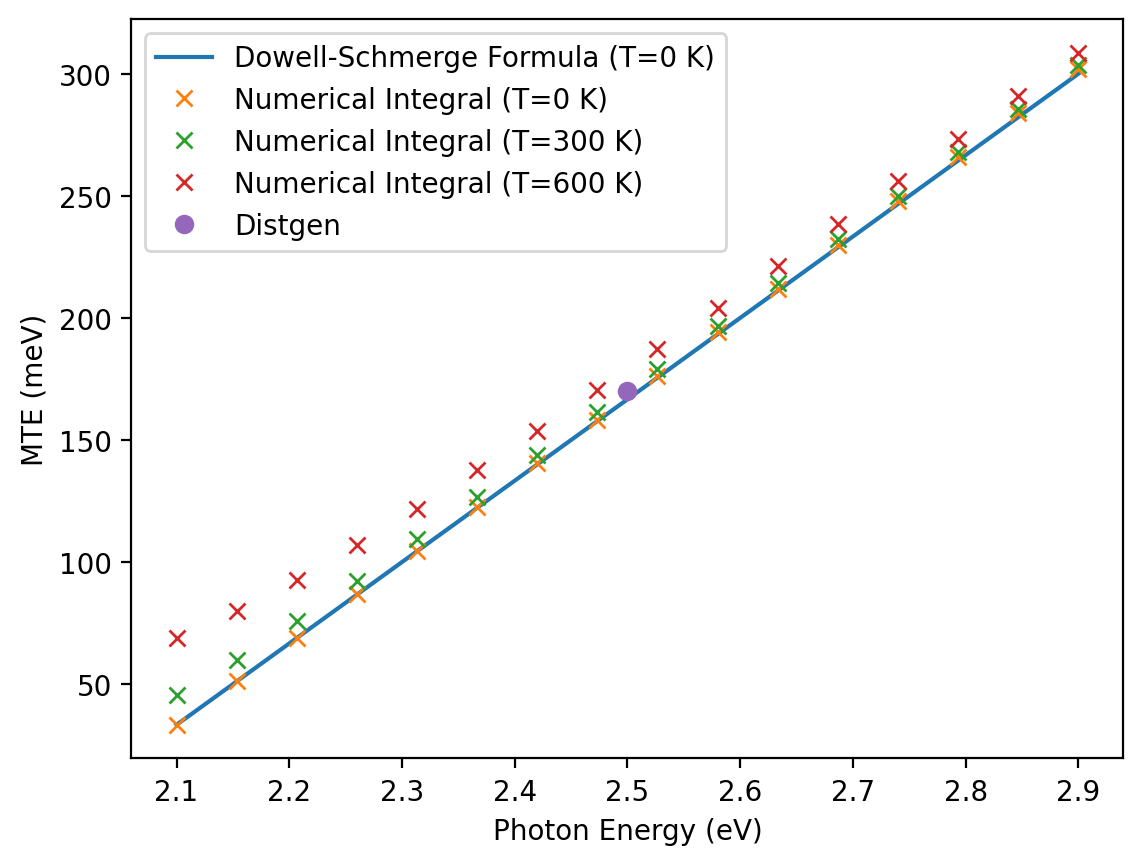

In [11]:
# Plot the MTE vs photon energy and temp
def get_mte(fermi_energy, t, photon_energy, workfun, n_points=128):
    # mc2 = 511e3
    (bxm, bxp), (bym, byp), (bzm, bzp) = dowell_schmerge_pdf_bounds(
        photon_energy, workfun, t, fermi_energy
    )
    px, py, pz = np.mgrid[
        bxm : bxp : 1j * n_points, bym : byp : 1j * n_points, bzm : bzp : 1j * n_points
    ]
    rho = dowell_schmerge_pdf(px, py, pz, photon_energy, workfun, t, fermi_energy)
    norm = np.trapezoid(
        np.trapezoid(
            np.trapezoid(rho, dx=px[1, 0, 0] - px[0, 0, 0], axis=0),
            dx=py[0, 1, 0] - py[0, 0, 0],
            axis=0,
        ),
        dx=pz[0, 0, 1] - pz[0, 0, 0],
    )
    px_sec_moment = np.trapezoid(
        np.trapezoid(
            np.trapezoid(px**2 * rho, dx=px[1, 0, 0] - px[0, 0, 0], axis=0),
            dx=py[0, 1, 0] - py[0, 0, 0],
            axis=0,
        ),
        dx=pz[0, 0, 1] - pz[0, 0, 0],
    )
    return (px_sec_moment / norm) / mc2 * 1e3


ephoton = np.linspace(2.1, 2.9, 16)
plt.plot(ephoton, (ephoton - 2) / 3 * 1e3, label="Dowell-Schmerge Formula (T=0 K)")

for temp in [0, 300, 600]:
    mte = np.array([get_mte(6.0, temp, ep, 2.0) for ep in ephoton])
    plt.plot(
        ephoton,
        mte,
        marker="x",
        ls="none",
        label="Numerical Integral (T=%.0f K)" % temp,
    )

plt.plot(photon_energy, 1000 * P["sigma_px"] ** 2 / MC2.magnitude, "o", label="Distgen")

plt.legend()
plt.xlabel("Photon Energy (eV)")
plt.ylabel("MTE (meV)")

## Internal Distgen |P|, $\phi$ Distribution Object

In [12]:
from distgen.dist import FermiDirac3StepBarrierMomentumDist

In [13]:
params = {
    "photon_wavelength": laser_wavelength,
    "work_function": cathode_work_function,
    "temperature": cathode_temperature,
    "fermi_energy": fermi_energy,
}

dscm = FermiDirac3StepBarrierMomentumDist(verbose=0, **params)

In [14]:
from distgen.dist import random_generator

In [15]:
n_sample = 1_000_000
rns = random_generator((3, n_sample), "hammersley")

In [16]:
print(rns.shape)

(3, 1000000)


In [17]:
ps, phis = dscm.cdfinv(rns[0, :], rns[1, :])
thetas = np.linspace(0, 2 * np.pi, len(ps)) * unit_registry("rad")

In [18]:
px = ps * np.cos(thetas) * np.sin(phis)
py = ps * np.sin(thetas) * np.sin(phis)
pz = ps * np.cos(phis)

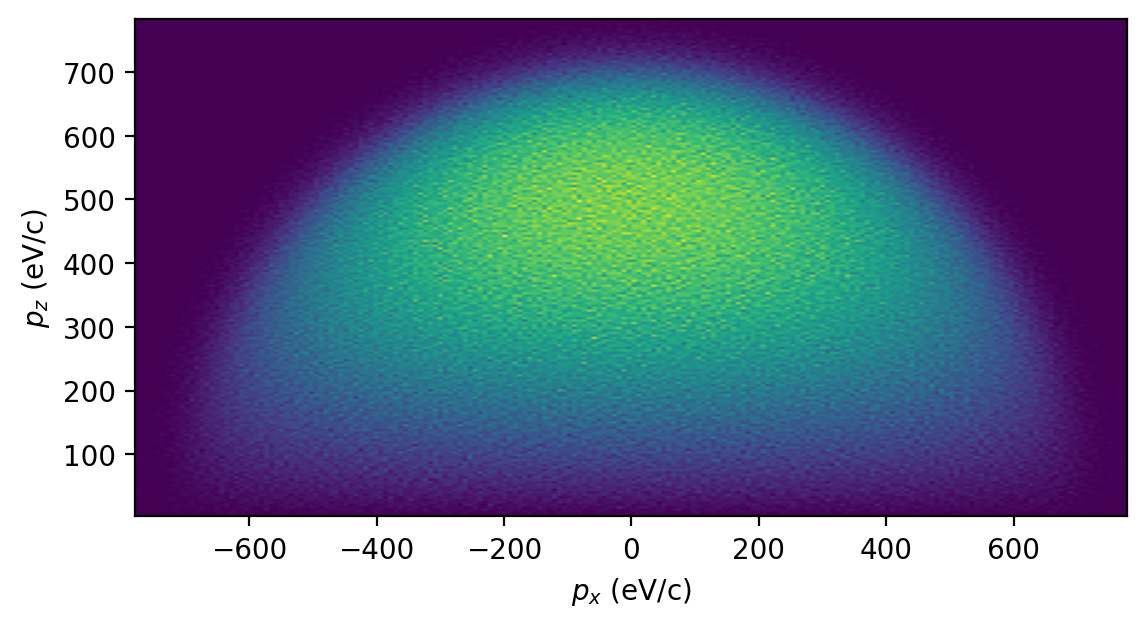

In [19]:
hist, xes, yes = np.histogram2d(px.magnitude, pz.magnitude, bins=200)
xcs = (xes[:-1] + xes[1:]) / 2
ycs = (yes[:-1] + yes[1:]) / 2

plt.imshow(hist.transpose(), origin="lower", extent=(xcs[0], xcs[-1], ycs[0], ycs[-1]))
plt.xlabel("$p_x$ (eV/c)")
plt.ylabel("$p_z$ (eV/c)");

In [20]:
np.mean(px**2) / MC2

<Quantity(0.169860223, 'electron_volt / speed_of_light ** 2')>

In [21]:
print("estimated MTE:", 1000 * P["sigma_px"] ** 2 / MC2.magnitude, "meV")

estimated MTE: 169.86745103445492 meV


In [22]:
KE = ((px**2 + py**2 + pz**2) / 2 / me).to("eV")

Text(0, 0.5, 'Probability')

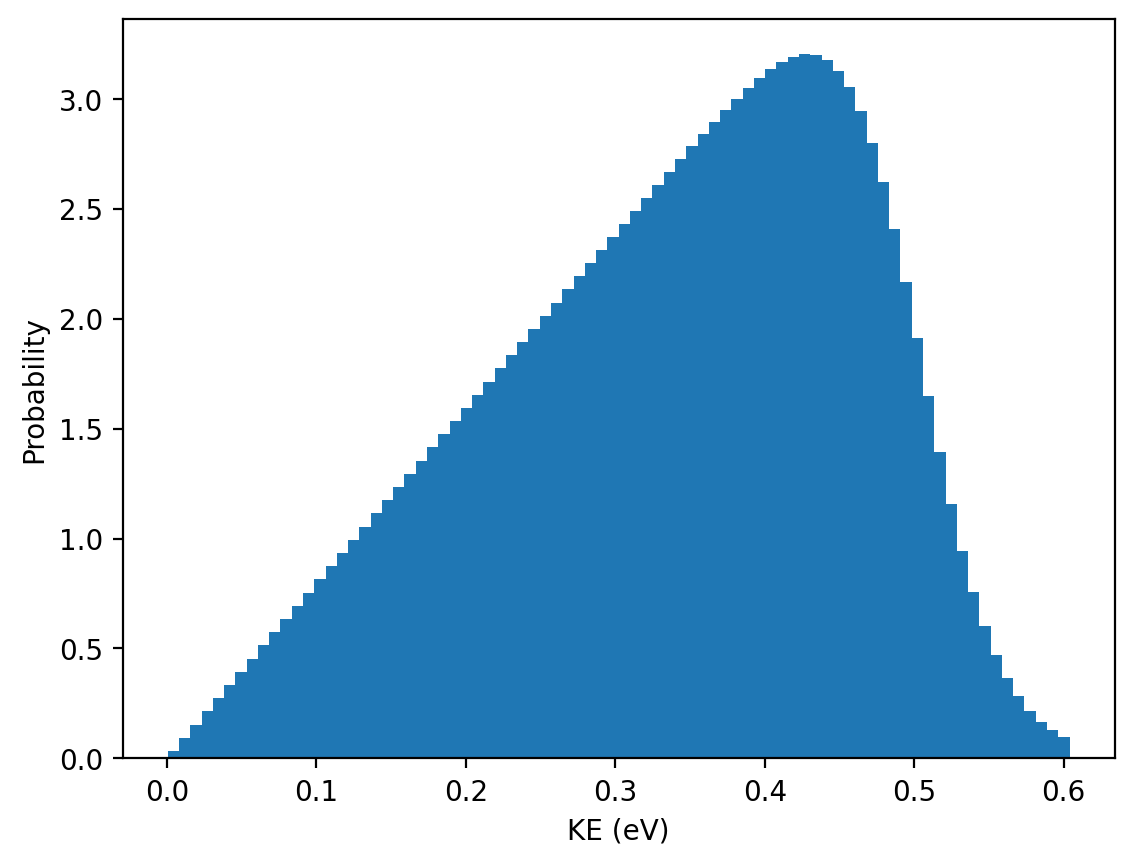

In [23]:
plt.hist(KE, bins=80, density=True)
plt.xlabel("KE (eV)")
plt.ylabel("Probability")